## Using Atom to compute populations and emissivities

The __Atom__ class is equipped with method which give access to the populations, emissivities, and other atomic quantities:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn
O3 = pn.Atom('O', 3)
N2 = pn.Atom('N', 2)
S2 = pn.Atom('S', 2)

In [2]:
O3.getEnergy(4, unit='eV')

2.513565018800101

In [3]:
O3.getStatWeight(level=4)

5.0

In [4]:
O3.getPopulations(tem=1.0e4, den=1e2)

array([7.81643685e-01, 1.93870586e-01, 2.44814197e-02, 4.30930821e-06,
       2.97166313e-10])

In [5]:
O3.getPopulations(tem=1.5e4, den=1e2)

array([8.02454816e-01, 1.75280839e-01, 2.22544005e-02, 9.94241529e-06,
       2.05075367e-09])

In [6]:
O3.getPopulations(tem=1e4, den=1e2).sum()

1.0

In [9]:
print('Critical densities')
print('N2 : ' + ' '.join('{:8.2e}'.format(cd) for cd in N2.getCritDensity(tem=12000)))
print('O3 : ' + ' '.join('{:8.2e}'.format(cd) for cd in O3.getCritDensity(tem=12000)))


Critical densities
N2 : 0.00e+00 4.06e+01 2.47e+02 9.55e+04 1.74e+07 9.83e+09
O3 : 0.00e+00 5.31e+02 3.70e+03 7.31e+05 2.61e+07


In [10]:
O3.getEmissivity(tem=1e4, den=1e2, wave=5007) # in erg.s-1.cm3

array(3.49707371e-21)

Wavelengths should be entered with enough precision to avoid confusion with nearby lines. Use __printTransition__ to check if the transition selected by the code actually correponds to the one you intended: 

In [11]:
O3.printTransition(5007)

Input wave: 5007.0
Closest wave found: 5006.8
Relative error: 3E-05 
Transition: 4 -> 3


__getTransition__ is an abridged version which only returns the tuple of levels rather than an extended output, and is therefore apt to be used in scripts.

In [12]:
O3.getTransition(5007)

(4, 3)

Or you can explicitly use the levels corresponding to the transition:

In [13]:
O3.getEmissivity(tem=1e4, den=1e2, lev_i=4, lev_j=3)

array(3.49707371e-21)

In the case of __getEmissivity__, tem and den can be arrays. In such a case, if they have different dimensions N and M, the function will return an array of NxM emissivities corresponding to all tem-den combinations; if both arrays have the same dimension, you can obtain the emissivities of either the NxN array of tem-den combinations as in the previous case, or of the 1D, N-length array obtained pairing tem and den element by element. This is controlled by the “product” parameter, the default being True (results is NxN matrix):

In [14]:
O3.getEmissivity([10000, 12000], [100, 500], 4, 2, product=True)

array([[1.17195376e-21, 1.18350278e-21],
       [1.79323749e-21, 1.80805851e-21]])

In [15]:
O3.getEmissivity([10000, 12000], [100, 500], 4, 2, product=False)

array([1.17195376e-21, 1.80805851e-21])

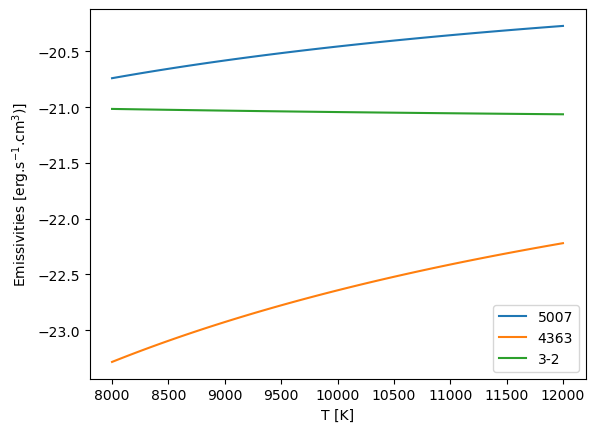

In [50]:
tem = np.linspace(8000, 12000, 100)
f, ax = plt.subplots()
ax.plot(tem, np.log10(O3.getEmissivity(tem, 1e2, wave=5007)),label='5007')
ax.plot(tem, np.log10(O3.getEmissivity(tem, 1e2, wave=4363)), label='4363')
ax.plot(tem, np.log10(O3.getEmissivity(tem, 1e2, lev_i=3, lev_j=2)), label='3-2')
ax.legend()
ax.set_xlabel('T [K]')
ax.set_ylabel(r'Emissivities [erg.s$^{-1}$.cm$^3$)]');


## Physical conditions determined from line ratios

The __Atom__ object also contains a method to compute the electron temperature or density given a line ratio:

In [2]:
O3.getTemDen(int_ratio=150., den=100., wave1=5007, wave2=4363)

10070.1086130086

The keyword tem (or den) specifies the supplied value of the temperature (or density). Which quantity is computed (temperature or density) is determined by which quantity is provided to the method: if “den” is given, then “tem” is computed, and vice versa.

If the intensity ratio is a simple ratio of two transitions, you can:

- either give the wavelengths of the two transitions involved: 

In [3]:
O3.getTemDen(0.02, den=1.e4,  wave1=4363, wave2=5007)

14923.313659752961

- or give the four levels that define the two transitions, in the following order: (upper level of numerator) (lower level of numerator) (upper level of denominator) (lower level of denominator); e. g.:

In [4]:
O3.getTemDen(0.02, den=1.e4, lev_i1=5, lev_j1=4, lev_i2=4, lev_j2=3)

14923.313659752961

In the general case of an intensity ratio formed by any number of transitions, an algebraic expression must be supplied as the argument of the keyword __to_eval__:

In [19]:
O3.getTemDen(0.02, den=1.e4, to_eval="I(5, 4) / (I(4, 3) + I(4, 2))" )

17201.456195718863

In [20]:
N2.getTemDen(150., den=100., to_eval = "(L(6584) + L(6548)) / L(5755)")

8303.6441184966

The __to_eval__ argument accepts either I(i, j) or L(wavelength) to identify the transitions involved in the diagnostic. Both can be mixed in the same string. If you do not know what transition corresponds to a given wavelength, use __printTransition__ to find it.

The parameters __tem__ and __den__, as well as the line ratio, may be arrays (1D or 2D, as in the case of observations obtained from IFUs), in which case the result will have the same shape. Some restrictions can be set to the domain explored by the method when looking for the solution; see the method's documentation for further details.

In [21]:
O3.getTemDen([0.015, 0.019], den=[1.e4, 1.1e4], to_eval="I(5, 4) / (I(4, 3) + I(4, 2))")

array([14936.84544261, 16724.87927208])

In [22]:
O3.getTemDen([0.015, 0.019], den=1.e4, to_eval="I(5, 4) / (I(4, 3) + I(4, 2))")

array([14936.84544261, 16755.22374476])

Notice that if you want to simultaneously determine both temperature and density combining two diagnostics (from two different atoms), you need to use the __getCrossTemDen__ method of the __Diagnostic__ class

Example of use in the case of density determination:

In [9]:
S2.getTemDen(1.1, tem = 1e4, wave1=6730, wave2 = 6716)

1018.3883056428102

## Ionic abundance determination

The ionic abundance is obtained from the intensity of a line normalized to Hbeta=100.

In [20]:
O3.getIonAbundance(int_ratio=127, tem=12.e3, den=10., wave=5007, tem_HI=1.5e4, den_HI=1)

2.048873324148938e-05

In [11]:
S2.getIonAbundance(int_ratio=72, tem=1.5e4, den=100., to_eval='L(6716)+L(6731)')

7.532337973815044e-07

The ionic abundance from recombination lines is treated below

## Creating a dictionary of Atom objects

You can define all the atoms at once and put them in a dictionary by creating each atom at a time through the commands:

In [26]:
O3 = pn.Atom('O', '3')
O2 = pn.Atom('O', '2')
N2 = pn.Atom('N', '2')

or rather use one of the following shortcuts:

In [27]:
atoms = pn.getAtomDict() # a method always requires parenthesis, even without argument

warng _ManageAtomicData: rec data not available for Al2
warng _ManageAtomicData: rec data not available for Ar2
warng _ManageAtomicData: rec data not available for Ar3
warng _ManageAtomicData: rec data not available for Ar4
warng _ManageAtomicData: rec data not available for Ar5
warng _ManageAtomicData: rec data not available for Ba2
warng _ManageAtomicData: rec data not available for Ba4
ERROR None: No data for this case B
ERROR None: No data for this case B
warng _ManageAtomicData: rec data not available for Ca5
warng _ManageAtomicData: rec data not available for Cl2
warng _ManageAtomicData: rec data not available for Cl3
warng _ManageAtomicData: rec data not available for Cl4
warng _ManageAtomicData: rec data not available for Fe3
warng _ManageAtomicData: rec data not available for K4
warng _ManageAtomicData: rec data not available for K5
warng _ManageAtomicData: rec data not available for Mg5
warng _ManageAtomicData: rec data not available for Mg7
ERROR None: No data for this case 

In [28]:
atoms # All the available atoms

{'Al2': Atom Al2 from al_ii_atom_JSP86-HK87-VVF96-KS86.dat and al_ii_coll_KHAF92-TBK85-TBK84.dat,
 'Ar2': Atom Ar2 from ar_ii_atom_Bal06.dat and ar_ii_coll_PB95.dat,
 'Ar3': Atom Ar3 from ar_iii_atom_MB09.dat and ar_iii_coll_MB09.dat,
 'Ar4': Atom Ar4 from ar_iv_atom_RGJ19.dat and ar_iv_coll_RB97.dat,
 'Ar5': Atom Ar5 from ar_v_atom_LL93-MZ82-KS86.dat and ar_v_coll_GMZ95.dat,
 'Ba2': Atom Ba2 from ba_ii_atom_C04.dat and ba_ii_coll_SB98.dat,
 'Ba4': Atom Ba4 from ba_iv_atom_BHQZ95.dat and ba_iv_coll_SB98.dat,
 'C1': Atom C1 from c_i_atom_FFS85.dat and c_i_coll_JBK87-PA76.dat,
 'C1r': Atom C1 from c_i_rec_P91.func,
 'C2': Atom C2 from c_ii_atom_GMZ98.dat and c_ii_coll_BP92.dat,
 'C2r': Atom C2 from c_ii_rec_D00.func,
 'C3': Atom C3 from c_iii_atom_G83-NS78-WFD96.dat and c_iii_coll_Bal85.dat,
 'C4': Atom C4 from c_iv_atom_WFD96.dat and c_iv_coll_AK04.dat,
 'Ca5': Atom Ca5 from ca_v_atom_M83-KS86.dat and ca_v_coll_GMZ95.dat,
 'Cl2': Atom Cl2 from cl_ii_atom_MZ83.dat and cl_ii_coll_T04.dat,

It is also possible to select only a subset of the elements or ions available by specifying the arguments __elem_list__ or __atom_list__:

In [29]:
print(len(atoms))

74


In [30]:
atoms = pn.getAtomDict(elem_list=['C', 'N', 'O']) # all the ions with spectra from 1 to 6 are created

ERROR None: No data for this case B
ERROR None: No data for this case B
warng _ManageAtomicData: data for C5 not available
warng _ManageAtomicData: data for C5 not available
warng _ManageAtomicData: data for C5 not available
warng _ManageAtomicData: data for C6 not available
warng _ManageAtomicData: data for C6 not available
warng _ManageAtomicData: data for C6 not available
warng _ManageAtomicData: data for C7 not available
warng _ManageAtomicData: data for C7 not available
warng _ManageAtomicData: data for C7 not available
ERROR None: No data for this case B
warng _ManageAtomicData: atom data not available for N5
warng _ManageAtomicData: coll data not available for N5
ERROR None: No data for this case B
warng _ManageAtomicData: data for N6 not available
warng _ManageAtomicData: data for N6 not available
warng _ManageAtomicData: data for N6 not available
warng _ManageAtomicData: data for N7 not available
warng _ManageAtomicData: data for N7 not available
warng _ManageAtomicData: data 

In [31]:
atoms # All the CNO available atoms

{'C1': Atom C1 from c_i_atom_FFS85.dat and c_i_coll_JBK87-PA76.dat,
 'C1r': Atom C1 from c_i_rec_P91.func,
 'C2': Atom C2 from c_ii_atom_GMZ98.dat and c_ii_coll_BP92.dat,
 'C2r': Atom C2 from c_ii_rec_D00.func,
 'C3': Atom C3 from c_iii_atom_G83-NS78-WFD96.dat and c_iii_coll_Bal85.dat,
 'C4': Atom C4 from c_iv_atom_WFD96.dat and c_iv_coll_AK04.dat,
 'N1': Atom N1 from n_i_atom_KS86-WFD96.dat and n_i_coll_PA76-DMR76.dat,
 'N1r': Atom N1 from n_i_rec_P91.func,
 'N2': Atom N2 from n_ii_atom_FFT04.dat and n_ii_coll_T11.dat,
 'N2r': Atom N2 from n_ii_rec_FSL11.func,
 'N3': Atom N3 from n_iii_atom_GMZ98.dat and n_iii_coll_BP92.dat,
 'N3r': Atom N3 from n_iii_rec_P91.func,
 'N4': Atom N4 from n_iv_atom_WFD96.dat and n_iv_coll_RBHB94.dat,
 'O1': Atom O1 from o_i_atom_WFD96.dat and o_i_coll_BK95.dat,
 'O1r': Atom O1 from o_i_rec_P91.func,
 'O2': Atom O2 from o_ii_atom_Z82-WFD96.dat and o_ii_coll_Kal09.dat,
 'O2r': Atom O2 from o_ii_rec_SSB17-B-opt.hdf5,
 'O3': Atom O3 from o_iii_atom_FFT04-SZ00

In [32]:
atoms = pn.getAtomDict(atom_list=['O2', 'O3', 'Ar3', 'N2'])

warng _ManageAtomicData: rec data not available for Ar3


In [33]:
atoms

{'O2': Atom O2 from o_ii_atom_Z82-WFD96.dat and o_ii_coll_Kal09.dat,
 'O2r': Atom O2 from o_ii_rec_SSB17-B-opt.hdf5,
 'O3': Atom O3 from o_iii_atom_FFT04-SZ00.dat and o_iii_coll_SSB14.dat,
 'O3r': Atom O3 from o_iii_rec_P91.func,
 'Ar3': Atom Ar3 from ar_iii_atom_MB09.dat and ar_iii_coll_MB09.dat,
 'N2': Atom N2 from n_ii_atom_FFT04.dat and n_ii_coll_T11.dat,
 'N2r': Atom N2 from n_ii_rec_FSL11.func}

In all these cases, a dictionary is created whose keys are the conventional atom names $<$element$><$spectrum$>$, and the corresponding entries the atoms themselves; e. g.:

In [34]:
atoms['N2']

Atom N2 from n_ii_atom_FFT04.dat and n_ii_coll_T11.dat

In [35]:
atoms['N2'].getEmissivity(tem=1e4, den=1e2, wave=6584)   # example of use

array(5.9490128e-21)

This can be useful if you need to loop on a list of atoms, to plot atomic data for example. To see what atoms have been created (which is limited by the data included in the selected atomic data set), enter:

In [36]:
atoms.keys()

dict_keys(['O2', 'O2r', 'O3', 'O3r', 'Ar3', 'N2', 'N2r'])

If you want to be able to access them directly rather than through a dictionary, input from the command line:

In [37]:
for key in atoms.keys():
    vars()[key]=atoms[key]

and then you will be able to do the following:

In [38]:
Ar3.NLevels

5